In [651]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import csv
import pandas
import random

In [652]:
months = {'jan':1, 'feb':2, 'mar':3,
          'apr':4, 'may':5, 'jun':6,
          'jul':7, 'aug':8, 'sep':9,
          'oct':10, 'nov':11, 'dec':12}

#### Подготовим данные:

In [653]:
data = []
csvfile = open('forestfires.csv')
file_data = pandas.read_csv(csvfile)

del file_data['day']  # убираем значение дня
file_data['a'] = 1  # добавляем фиктивный столбец
for i in range(len(file_data)):
    file_data.loc[i,'month'] = float(months[file_data.loc[i, 'month']])  # преобразуем месяц к числовому типу

In [654]:
# помещаем колонку area в конец:
cols = file_data.columns.tolist()
num_of_cols = len(cols)
new_cols = cols[:num_of_cols - 2] + [cols[num_of_cols-1]] + [cols[num_of_cols-2]]
ordered_data = file_data[new_cols]

In [655]:
data = np.array(pandas.DataFrame.as_matrix(ordered_data))  # преобразовываем данные в матрицу
np.random.shuffle(data)

## Оценка $area$

In [656]:
def parse_data(d):
    learning_data = {'coef' : np.array((d[:int(0.7 * len(data)), :-1]).tolist()),
                 'answer': np.array((d[:int(0.7 * len(data)), -1]).tolist())
                 }
    testing_data = {'coef' : np.array((d[int(0.7 * len(data)):, :-1]).tolist()),
                'answer': np.array((d[int(0.7 * len(data)):, -1]).tolist())
                }
    return (learning_data, testing_data)

In [657]:
len_of_data = len(data)
parsed_data = parse_data(data)
learning_data = parsed_data[0]
testing_data = parsed_data[1]

In [658]:
def get_regresion_coefs(Z, X):
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(Z), Z)),np.transpose(Z)), X)
def get_esstimation(Z, X):
    return np.dot(Z, X)

In [659]:
regression_coefs = get_regresion_coefs(learning_data['coef'], learning_data['answer'])

In [660]:
print(regression_coefs)

[  0.98860613   0.60321629   1.29516212  -0.08087268   0.14824062
  -0.02349912  -0.07278719  -0.16793161  -0.32047523   0.52991999
  -1.35511825  13.9560451 ]


In [661]:
def get_delta(x, y):
    return np.power(np.average(np.power(x - y, 2)), 0.5)

In [662]:
learninig_est = get_esstimation(learning_data['coef'], regression_coefs)
testing_est = get_esstimation(testing_data['coef'], regression_coefs)

print("Среднеквадратичное отклонение для тестирующей выборки: ", get_delta(testing_est, testing_data['answer']))

Среднеквадратичное отклонение для тестирующей выборки:  90.6256434889


## Преобразование $f(x) = ln(c+x)$

In [663]:
def get_transformed_data(c, data):
    data1 = np.array(data)
    np.random.shuffle(data1)
    data1[:, -1] = [np.log(x + c) for x in data1[:, -1]]
    return parse_data(data1)

In [664]:
def get_back_transformed_data(c, data):
    data1 = np.array(data)
    np.random.shuffle(data1)
    data1[:, -1] = [np.exp(x) - c for x in data1[:, -1]]  # обратное преобразование будет f(x) = e^x - c
    return parse_data(data1)

def back_transform_column(c, col):
    return [np.exp(x) - c for x in col]

In [681]:
(test, original_test) = ([], [])
for c in range(1, 2000):
    transformed_data = get_transformed_data(c, data)
    learning_data = transformed_data[0]
    testing_data = transformed_data[1]
    original_testing_data = parse_data(data)[1]
    
    regression_coefs = get_regresion_coefs(learning_data['coef'], learning_data['answer'])
    
    testing_est = get_esstimation(testing_data['coef'], regression_coefs)
    original_testing_est = back_transform_column(c, get_esstimation(original_testing_data['coef'], regression_coefs))
    
    test.append(get_delta(testing_est, testing_data['answer']))
    original_test.append(get_delta(original_testing_est, original_testing_data['answer']))

Построим график отклонения среднеквадратичного от $c:$

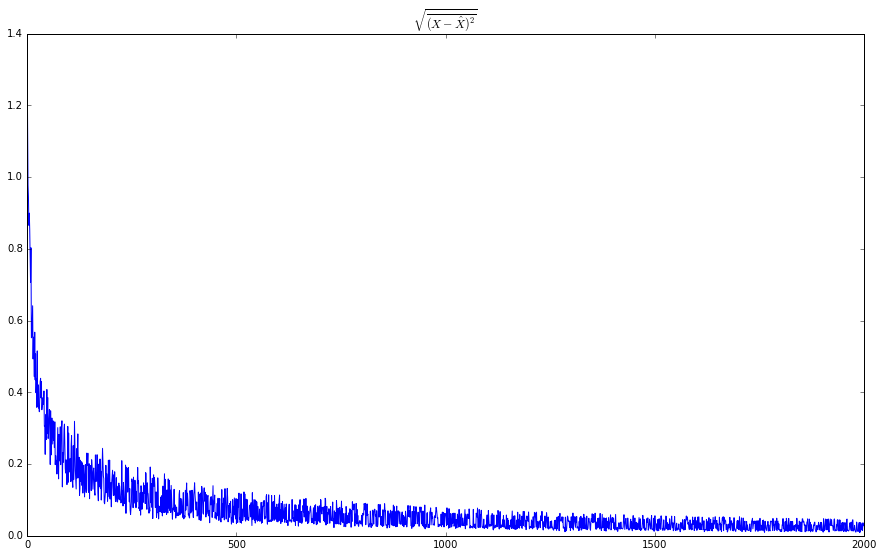

In [666]:
plt.figure(figsize=(15, 9))
plt.title('$\sqrt{\overline{(X - \hat{X})^2}}}$')
plt.plot(test)

Из графика видно, что при больших $c$ отклонение меньше.

In [669]:
c = 2000
(test, original_test) = ([], [])
for i in range(1, 100):
    np.random.shuffle(data)
    transformed_data = get_transformed_data(c, data)
    learning_data = transformed_data[0]
    testing_data = transformed_data[1]
    original_testing_data = parse_data(data)[1]
    
    regression_coefs = get_regresion_coefs(learning_data['coef'], learning_data['answer'])
    
    testing_est = get_esstimation(testing_data['coef'], regression_coefs)
    original_testing_est = back_transform_column(c, get_esstimation(original_testing_data['coef'], regression_coefs))
    
    test.append(get_delta(testing_est, testing_data['answer']))
    original_test.append(get_delta(original_testing_est, original_testing_data['answer']))

In [675]:
print("Среднеквадратичное отклонение для тестирующей выборки: ",
          np.average(test))
print("Среднеквадратичное отклонение для исходной выборки с обратным преобразованием: ",
          np.average(original_test))

Среднеквадратичное отклонение для тестирующей выборки:  0.0265593216845
Среднеквадратичное отклонение для исходной выборки с обратным преобразованием:  57.5394177859


#### Посмотрим насколько сильный разброс задает перемешивания:

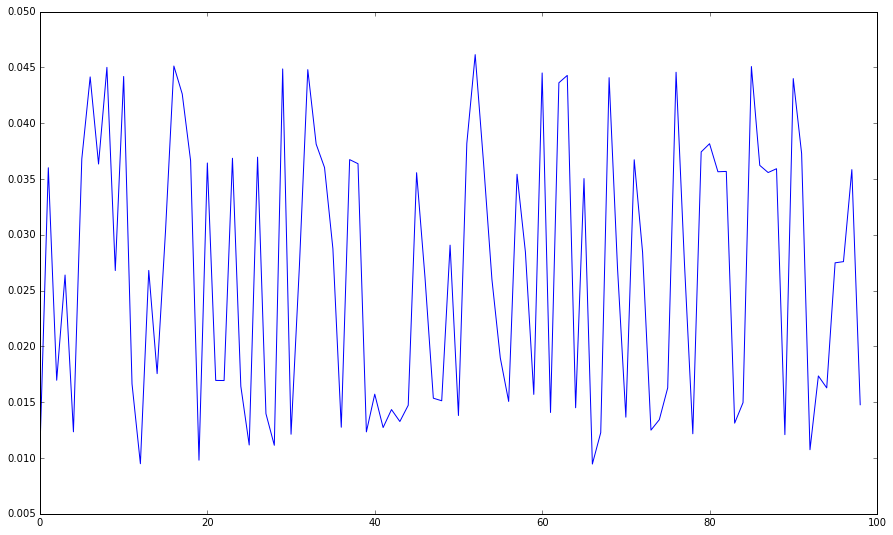

In [677]:
plt.figure(figsize=(15, 9))
plt.plot(test)

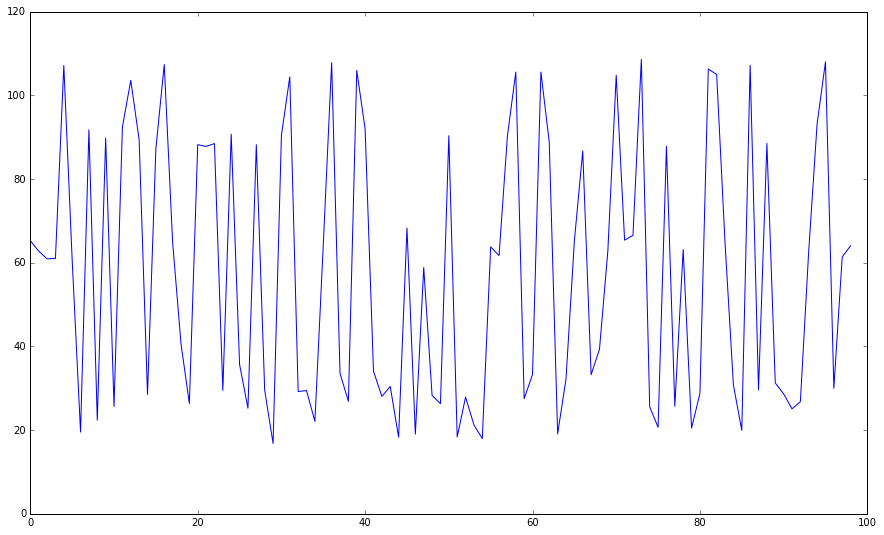

In [678]:
plt.figure(figsize=(15, 9))
plt.plot(original_test)

Итак, из графиков видно, что случайность вносит существенный вклад в отклонение. Дисперсия отклонения достигает сопостовимую по размерам величину с самим отклонением.

#### Вывод.
Преобразование $f(x) = ln(x+c)$ заметно улучшает оценку параметра $area$. Погрешность оценок заметна, причем причина этого в том, что выборка перемешивается.